<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/11-training-deep-neural-networks/vanishing_exploding_gradients_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanishing/Exploding Gradients Problems

You may need to train a much deeper DNN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep DNN isn’t a walk in the park. Here are some of the problems you could run into:

* You may be faced with the tricky vanishing gradients problem or the related exploding gradients problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.
* You might not have enough training data for such a large network, or it might be too costly to label.
* Training may be extremely slow.
* A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.
2.0.0


## Vanishing/Exploding Gradients Problem

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the vanishing gradients problem. 

In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces in recurrent neural networks.

This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio. 

The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. 

Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

### Logistic activation function saturation

Looking at the logistic activation function, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers,so there is really nothing left for the lower layers.

In [0]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

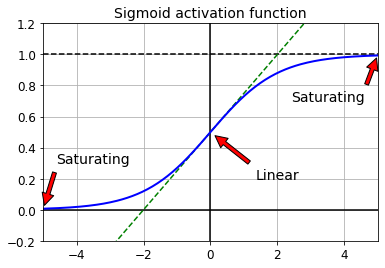

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')         # lower solid black line
plt.plot([-5, 5], [1, 1], 'k--')        # upper dashed black line

plt.plot([0, 0], [-0.2, 1.2], 'k-')     # zero divider black line
plt.plot([-5, 5], [-3/4, 7/4], 'g--')   # green dashed line

plt.plot(z, sigmoid(z), 'b-', linewidth=2)

props = dict(facecolor='red', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha='center')

plt.grid(True)
plt.title('Sigmoid activation function', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Glorot and He Initialization

Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. 

For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, 2 and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.

is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly.

This initialization strategy is called Xavier initialization or Glorot initialization , after the paper’s first author.

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting kernel_initializer="he_uniform" or kernel_initializer="he_normal" like this:

In [4]:
[name for name in dir(keras.initializers) if not name.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

If you want He initialization with a uniform distribution but based on fan avg rather than fan in , you can use the VarianceScaling initializer like this:

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

### Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs : during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. 

In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. 

A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU . This function is defined as LeakyReLU α(z) = max(αz,z). The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0 and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

In [0]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha * z, z)

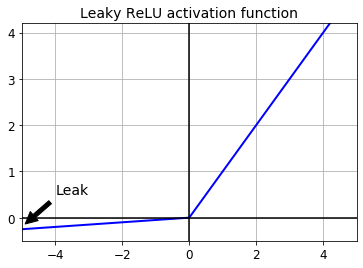

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [9]:
[name for name in dir(keras.activations) if not name.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, 